In [1]:
!pip install climateservaccess

In [3]:
### Declare libraries, parameters, and read in well data ###

import pandas as pd
from climateservaccess import datatypeDict

REGION = 'gambia'
DATATYPE = 'lis_soil_moisture'

original_data_path = f"../../data/original_data/climateserv/{DATATYPE}/{REGION}"
processed_data_path = f"../../data/processed_data/climateserv/{DATATYPE}/{REGION}"
LIS_soil_moisture_datatypes = [
    664, 665, 666, 667
]
weights = [0.05, 0.15, 0.3, 0.5] # weights for each datatype

# Read in well data
igrac_df = pd.read_csv(f'../../data/processed_data/igrac/igrac_{REGION}.csv')
wells_df = pd.read_csv(f'../../data/processed_data/igrac/wells_{REGION}.csv')
wells_df.head()

,ID,Name,Status,Latitude,Longitude,Ground surface elevation
0,0000058001,Yoro Beri Kunda,Active,13.498482,-14.757303,17.40
1,0000035001,Pakaliba,Active,13.517245,-15.242125,13.34
2,0000024001,Somita,Active,13.208963,-16.298932,27.31
3,0000023001,Taneneh,Active,13.233057,-16.504728,14.32
4,0000020007,Mandinari OB3,Active,13.362761,-16.637219,30.47


RED = URBAN 
GREEN = RURAL


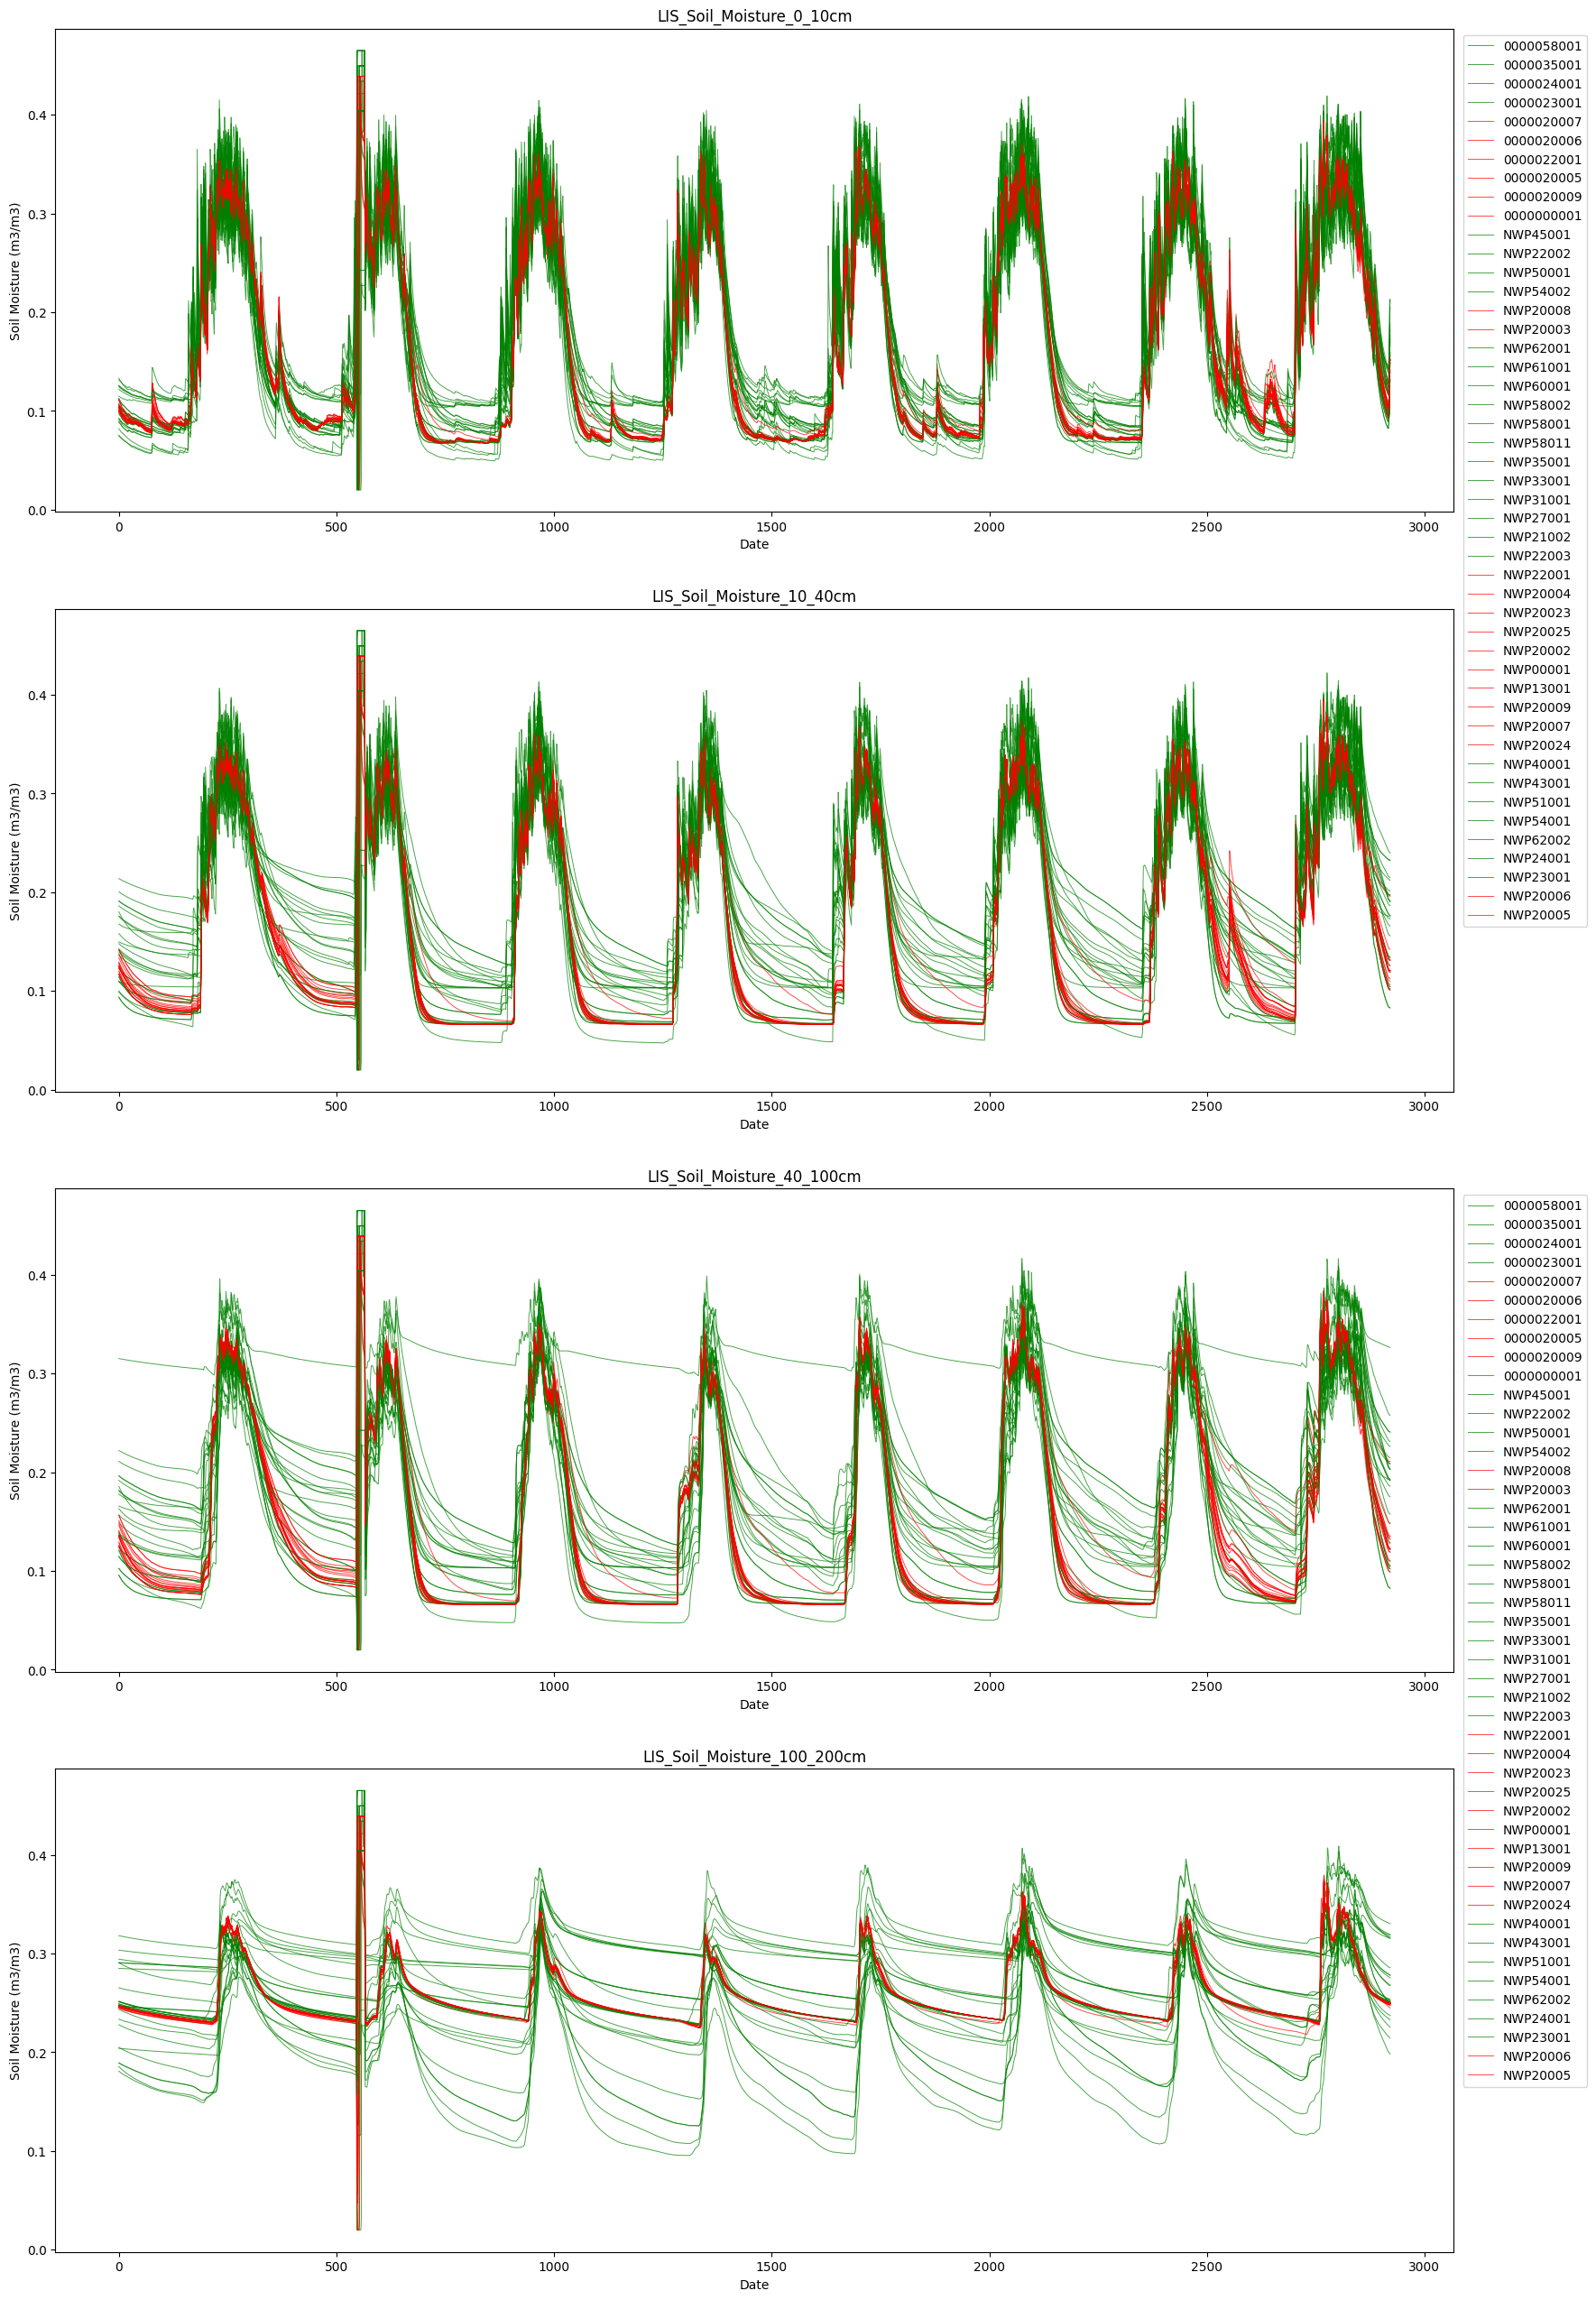

In [52]:
### Visualize soil moisture data for 0-10, 10-40, 40-100, 100-200 cm depths for each well ###

import matplotlib.pyplot as plt
from climateservaccess import datatypeDict

# Create 4 plots, one for each datatype, each with soil moisture vs date for all wells
plots = []
fig = plt.figure(figsize=(20, 32))
for datatype_num in LIS_soil_moisture_datatypes:
    datatype = datatypeDict[datatype_num]
    ax = fig.add_subplot(4, 1, datatype_num - 663)
    ax.set_title(f'{datatype}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Soil Moisture (m3/m3)')
    plots.append(ax)

for index, row in wells_df.iterrows():
    well = row['ID']

    # Read in csv data
    lis_df = pd.read_csv(f'{original_data_path}/{well}.csv')

    # Pick plot color
    if row['Longitude'] < -16.6 and row['Latitude'] > 13.31: # Urban Areas (Banjul)
        color = 'red'
    else: # Rural Areas
        color = 'green'
    # Add data to plot
    for datatype_num in LIS_soil_moisture_datatypes:
        datatype = datatypeDict[datatype_num]
        plots[datatype_num - 664].plot(lis_df.index, lis_df[datatype], label=well, linewidth=0.7, alpha=0.7, color=color)
        if datatype_num % 2 == 0: # Add legend for every other plot
            plots[datatype_num - 664].legend(loc='upper right', prop={'size': 10}, bbox_to_anchor=(1.1, 1.0)) 

print('RED = URBAN \nGREEN = RURAL')

plt.show()

RED = URBAN 
GREEN = RURAL


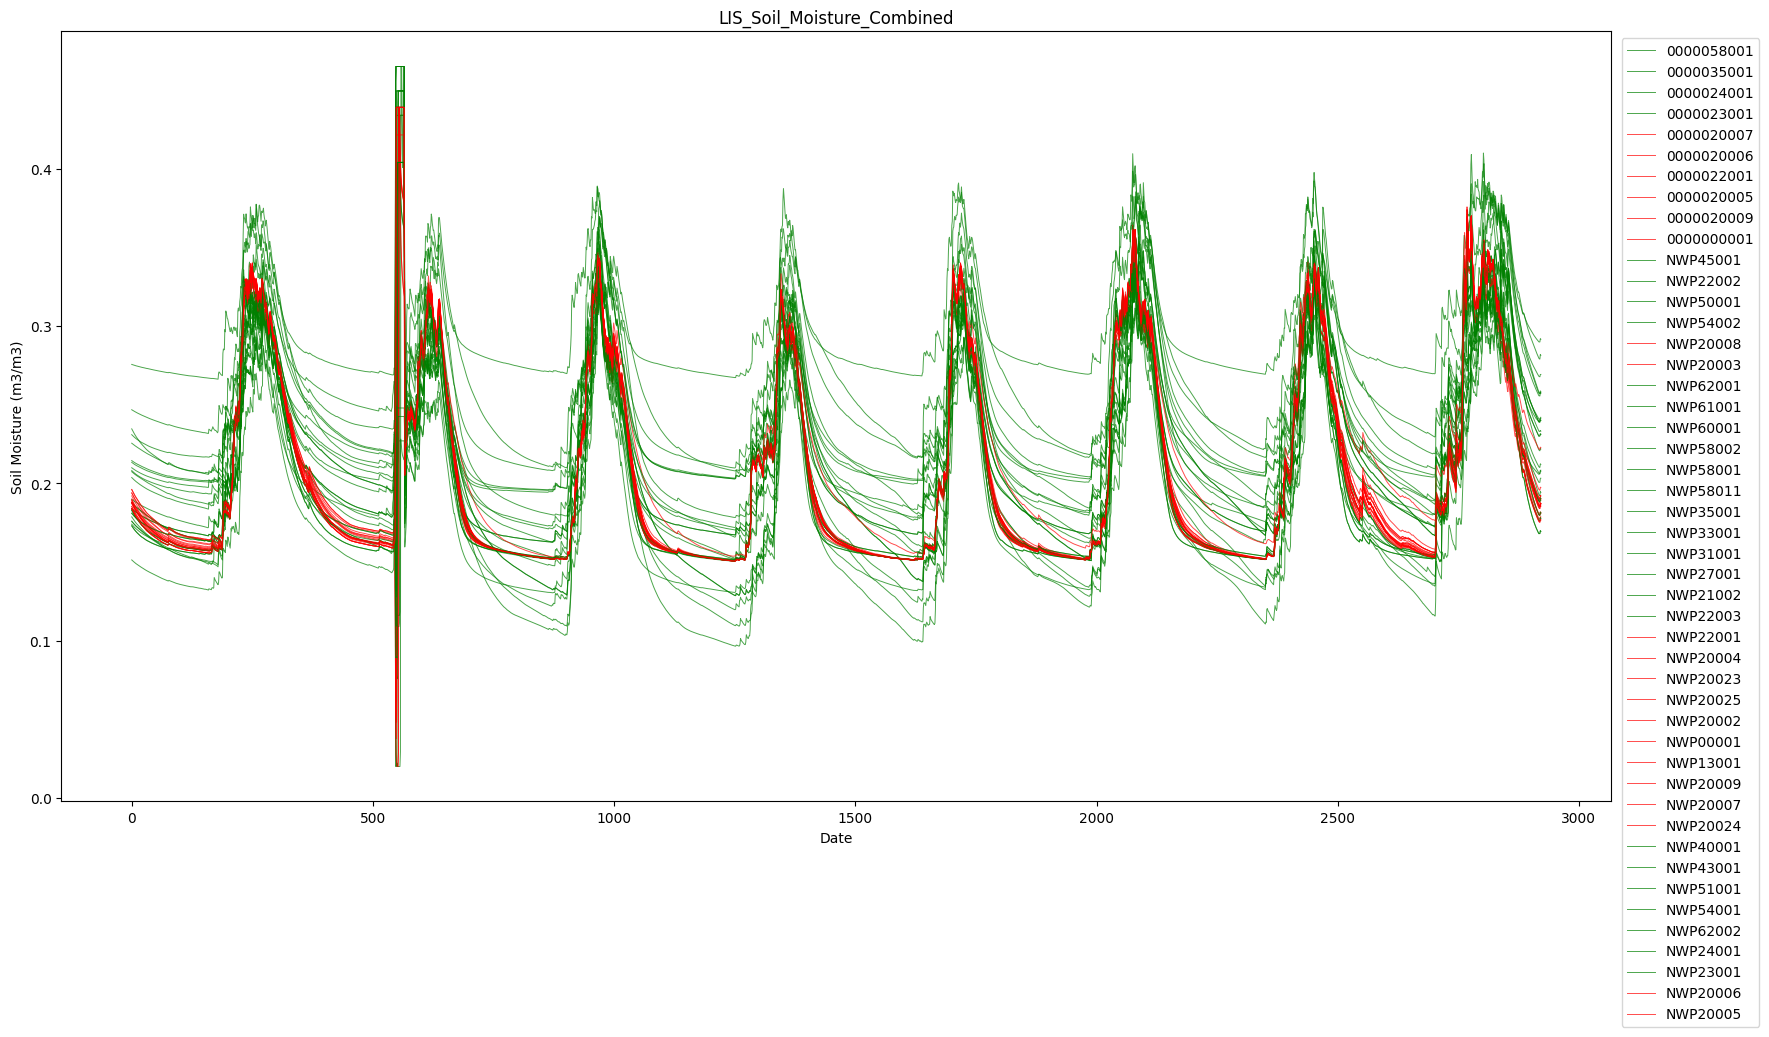

In [53]:
### Visualize soil moisture data for all depths combined for each well ###

# Plot "LIS_Soil_Moisture_Combined" vs date for all wells
plt.figure(figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Soil Moisture (m3/m3)')
plt.title(f'LIS_Soil_Moisture_Combined')
for index, row in wells_df.iterrows():
    well = row['ID']
    
    # Read in csv data
    lis_df = pd.read_csv(f'{original_data_path}/{well}.csv', parse_dates=True)
    
    # Create new column for a weighted average of all datatypes
    lis_df['LIS_Soil_Moisture_Combined'] = 0
    for i in range(len(LIS_soil_moisture_datatypes)):
        lis_df['LIS_Soil_Moisture_Combined'] += lis_df[datatypeDict[LIS_soil_moisture_datatypes[i]]] * weights[i]

    # Pick plot color
    if row['Longitude'] < -16.6 and row['Latitude'] > 13.31: # Urban Areas (Banjul)
        color = 'red'
    else: # Rural Areas
        color = 'green'

    # Plot
    plt.plot(lis_df.index, lis_df['LIS_Soil_Moisture_Combined'], label=well, linewidth=0.7, alpha=0.7, color=color)

plt.legend(loc='upper right', prop={'size': 10}, bbox_to_anchor=(1.1, 1.0))
print('RED = URBAN \nGREEN = RURAL')
plt.show()

In [59]:
### Export soil moisture data for all depths combined for each well ###

# Export "LIS_Soil_Moisture_Combined" vs date for all wells
for index, row in wells_df.iterrows():
    well = row['ID']
    
    # Read in csv data
    lis_df = pd.read_csv(f'{original_data_path}/{well}.csv', parse_dates=True)
    
    # Create new column for a weighted average of all datatypes
    lis_df['LIS_Soil_Moisture_Combined'] = 0
    for i in range(len(LIS_soil_moisture_datatypes)):
        lis_df['LIS_Soil_Moisture_Combined'] += lis_df[datatypeDict[LIS_soil_moisture_datatypes[i]]] * weights[i]

    # Remove all other columns
    lis_df = lis_df[['Date', 'LIS_Soil_Moisture_Combined']]
    
    # Export
    lis_df.to_csv(f'{processed_data_path}/{well}.csv', index=False)

print(f"Combined soil moisture data exported to {processed_data_path}")

Combined soil moisture data exported to ../../data/processed_data/climateserv/lis_soil_moisture/gambia


In [2]:
igrac_df.head()

,ID,GROUNDWATER_LEVEL,Date,Day,Month,Year,Latitude,Longitude,Ground surface elevation
0,NWP00001,14.26,2016-04-14,14,4,2016,13.420804,-16.716666,19.47
1,NWP00001,13.82,2015-12-26,26,12,2015,13.420804,-16.716666,19.47
2,NWP00001,13.83,2015-12-26,26,12,2015,13.420804,-16.716666,19.47
3,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47
4,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47


In [3]:
### Merge combined soil moisture data with igrac data ###

def read_soil_moisture(well):
    df = pd.read_csv(f'{processed_data_path}/{well}.csv', parse_dates=['Date'])
    df = df.set_index('Date')
    df = df.rename(columns={'LIS_Soil_Moisture_Combined': well})
    return df

# Read all soil moisture CSV files and concatenate them into one DataFrame with columns named for each
dfs = [read_soil_moisture(well) for well in igrac_df['ID'].unique()]
soil_moisture_df = pd.concat(dfs, axis=1)

# Merge soil moisture data with igrac data
merged_df = igrac_df.copy()
merged_df['LIS_Soil_Moisture_Combined'] = 0

for index, row in igrac_df.iterrows():

    well = row['ID']
    
    # Merge
    merged_df['LIS_Soil_Moisture_Combined'][index] = soil_moisture_df[well][row['Date']]

C:\Users\Adam Zheng\AppData\Local\Temp\ipykernel_24536\964640001.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['LIS_Soil_Moisture_Combined'][index] = soil_moisture_df[well][row['Date']]


In [4]:
merged_df.head()

,ID,GROUNDWATER_LEVEL,Date,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined
0,NWP00001,14.26,2016-04-14,14,4,2016,13.420804,-16.716666,19.47,0.172124
1,NWP00001,13.82,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837
2,NWP00001,13.83,2015-12-26,26,12,2015,13.420804,-16.716666,19.47,0.210837
3,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614
4,NWP00001,13.82,2015-12-25,25,12,2015,13.420804,-16.716666,19.47,0.211614


In [5]:
# Export merged data

merged_df.to_csv(f'../../data/processed_data/merged_data_{REGION}.csv', index=False)